In [1]:
from exp import *

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
dm = DatasetManager('2017',224,'all','2017')

In [4]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=0.0,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=224)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

# Adding attention

### Imports

In [5]:
import geffnet
from geffnet.efficientnet_builder import *

import types

In [6]:
DepthwiseSeparableConv and InvertedResidual and True

True

Hay que ponerle arl en inverted residuals y a depthwiseseparableconvs

## Normal forward funcs

In [7]:
def depthwise_separable_conv_forward(self, x):
        residual = x

        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.se(x)

        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.act2(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x += residual
        return x

In [8]:
def ir_forward(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
        x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x += residual
        return x

# EfficientNet baseline 

In [9]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)
random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.087503,0.637578,0.293333,0.706667,0.653333,00:06
1,0.918617,0.798605,0.360000,0.640000,0.606667,00:07


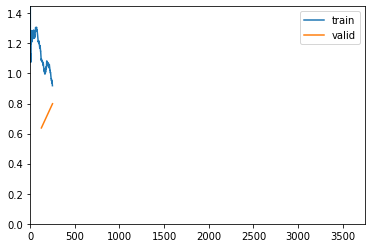

Process Process-1106:
Process Process-1115:
Process Process-1117:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff04eed8ef0>
Traceback (most recent call last):
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
Process Process-1119:
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

KeyboardInterrupt: 

  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 299, in _exit_function
    _run_finalizers(0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/util.py", line 299, in _exit_function
    _run_finalizers(0)
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 197, in _worker_loop
    if 

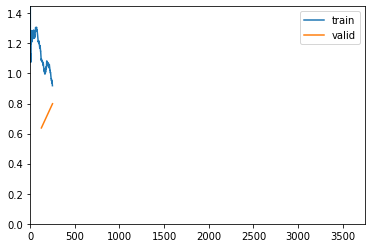

In [55]:
random_seed(1,True)
learn.fit_one_cycle(30, max_lr=slice(3e-03))

# EfficientNet Without Squeeze and Exite

In [10]:
alpha_initial_value = 0.001
def ir_forward_without_se(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
#         x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual
        return x


def remove_se(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Override forward func
    a_module.forward = types.MethodType(ir_forward_without_se,a_module)

def remove_se_from_model(m):
    apply_leaf(m, remove_se)

In [11]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

remove_se_from_model(model)

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph])

learn.unfreeze()

random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


KeyboardInterrupt: 

# EfficientNet Without Squeeze and Exite and with ARL

In [34]:
alpha_initial_value = 0.001
def attn_ir_forward_without_se(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
#         x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual + (residual 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha)
        return x


def change_inverted_residual_blocks_without_se(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_ir_forward_without_se,a_module)


def add_attn_geffnet_efficientnet_without_se(m):
    apply_leaf(m, change_inverted_residual_blocks_without_se)

In [35]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [36]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

add_attn_geffnet_efficientnet_without_se(model)
attn_blocks = [block for block in model.modules() if isinstance(block,InvertedResidual)]

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=attn_blocks)
                                     ])

learn.unfreeze()

In [37]:
random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


KeyboardInterrupt: 

NameError: name 'learn' is not defined

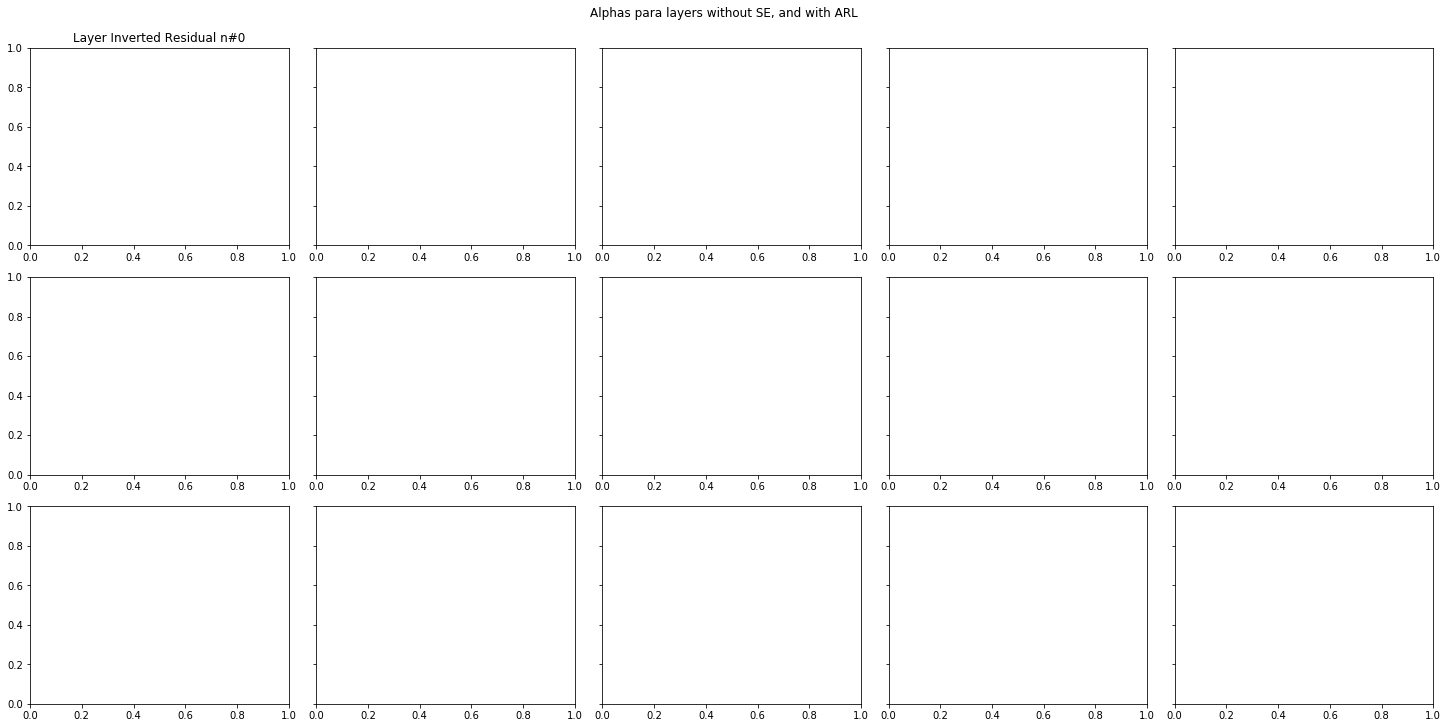

In [12]:
fig,axs = plt.subplots(3,5,figsize=(20,10), constrained_layout=True, sharey=True)

fig.suptitle('Alphas para layers without SE, and with ARL')

for i in range(15):
    axs[i//5][i%5].set_title(f"Layer Inverted Residual n#{i}")
    axs[i//5][i%5].plot(learn.alphas.stats[0][i])
    

# Efficientnet With Squeeze and Exite and With ARL

## Modify model

In [15]:
# alpha_initial_value = 0.001

# def attn_depthwise_separable_conv_forward(self, x):
#         residual = x

#         x = self.conv_dw(x)
#         x = self.bn1(x)
#         x = self.act1(x)

#         x = self.se(x)

#         x = self.conv_pw(x)
#         x = self.bn2(x)
#         x = self.act2(x)

#         if self.has_residual:
#             if self.drop_connect_rate > 0.:
#                 x = drop_connect(x, self.training, self.drop_connect_rate)
# #                 Aca no se entra nunca pues hay un solo bloque depthwise que no tiene residual
#             print('asd', self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x).shape)
#             x = x + residual + (residual * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) * self.alpha)
        
#         return x


# def change_depthwise_separable_blocks(a_module):
#     if not isinstance(a_module,DepthwiseSeparableConv): return
    
# #     Add params
#     a_module.softmaxLayer = nn.Softmax(2);
#     a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
# #     Override forward func
#     a_module.forward = types.MethodType(attn_depthwise_separable_conv_forward,a_module)


In [38]:
alpha_initial_value = 0.001
def attn_ir_forward(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
        x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual + (residual 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha)
        return x


def change_inverted_residual_blocks(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_ir_forward,a_module)


In [39]:
def add_attn_geffnet_efficientnet(m):
#     apply_leaf(m, change_depthwise_separable_blocks)
    apply_leaf(m, change_inverted_residual_blocks)

In [40]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [49]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

add_attn_geffnet_efficientnet(model)
attn_blocks = [block for block in model.modules() if isinstance(block,InvertedResidual)]

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=attn_blocks),
                                      OverSamplingCallback
                                     ])



epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.942316,0.616814,0.213333,0.786667,0.738333,00:11
1,0.645736,0.549967,0.220000,0.780000,0.725278,00:11
2,0.573552,0.454758,0.226667,0.773333,0.808056,00:11
3,0.538171,0.424198,0.213333,0.786667,0.807778,00:11


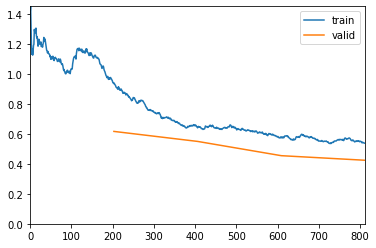

In [50]:
random_seed(1,True)
learn.fit_one_cycle(4, max_lr=slice(3e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.543313,0.411629,0.206667,0.793333,0.813889,00:16
1,0.514075,0.409685,0.213333,0.786667,0.826389,00:16
2,0.479660,0.408607,0.213333,0.786667,0.823889,00:16
3,0.471074,0.377513,0.173333,0.826667,0.829167,00:16
4,0.455264,0.393215,0.193333,0.806667,0.817500,00:16
5,0.427957,0.389364,0.193333,0.806667,0.838611,00:16
6,0.418586,0.375679,0.166667,0.833333,0.831111,00:16
7,0.364789,0.399315,0.166667,0.833333,0.820000,00:16
8,0.329889,0.411420,0.153333,0.846667,0.842500,00:16
9,0.298383,0.385885,0.166667,0.833333,0.854444,00:16


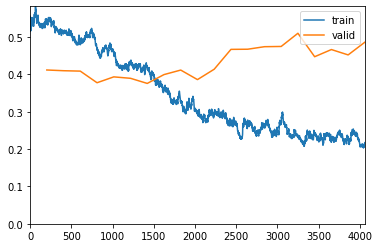

In [51]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(3e-04))

In [55]:
for b in attn_blocks:
    assert b.alpha.requires_grad

In [65]:
#Remove alphas which belong to layers without has_residuals

In [79]:
indexes_with_has_residual = [1,3,5,6,8,9,11,12,13]
real_alphas = learn.alphas.stats[0][indexes_with_has_residual]


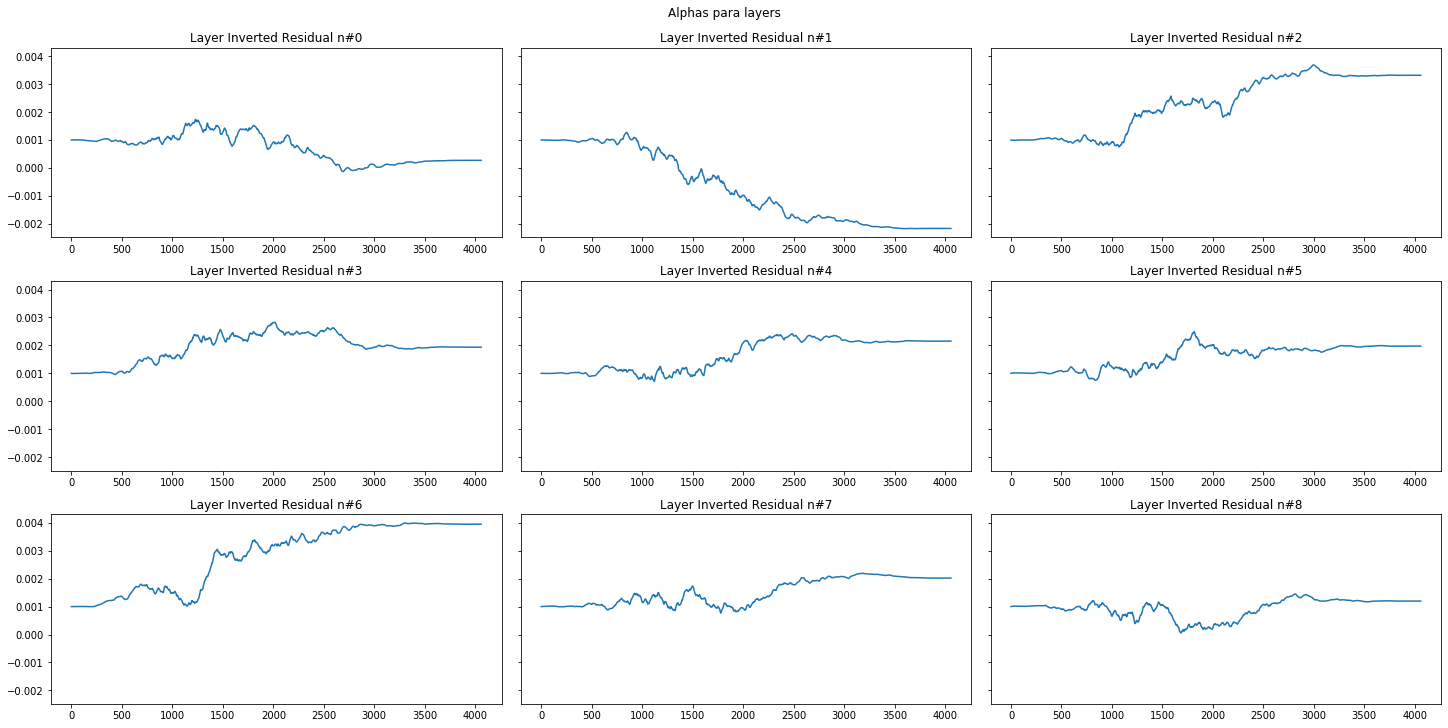

In [80]:
fig,axs = plt.subplots(3,3,figsize=(20,10), constrained_layout=True, sharey=True)

fig.suptitle('Alphas para layers')

for i in range(9):
    axs[i//3][i%3].set_title(f"Layer Inverted Residual n#{i}")
    axs[i//3][i%3].plot(real_alphas[i])
    

In [81]:
a_file = open("results/alphas_efficientnet.txt", "w")
for row in real_alphas:
    np.savetxt(a_file, row)

a_file.close()

In [82]:
real_alphas.shape

torch.Size([9, 4060])

In [83]:
original_array = np.loadtxt("results/alphas_efficientnet.txt").reshape(9, 4060)


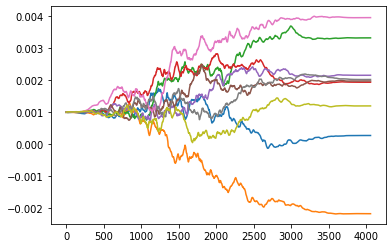

In [84]:
for i in range(len(original_array)):
    plt.plot(original_array[i])

In [42]:
learn.data.train_ds

LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .

In [43]:
np.linspace(0,20,21)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

In [44]:
batches_per_epoch_with_oversampling = 203

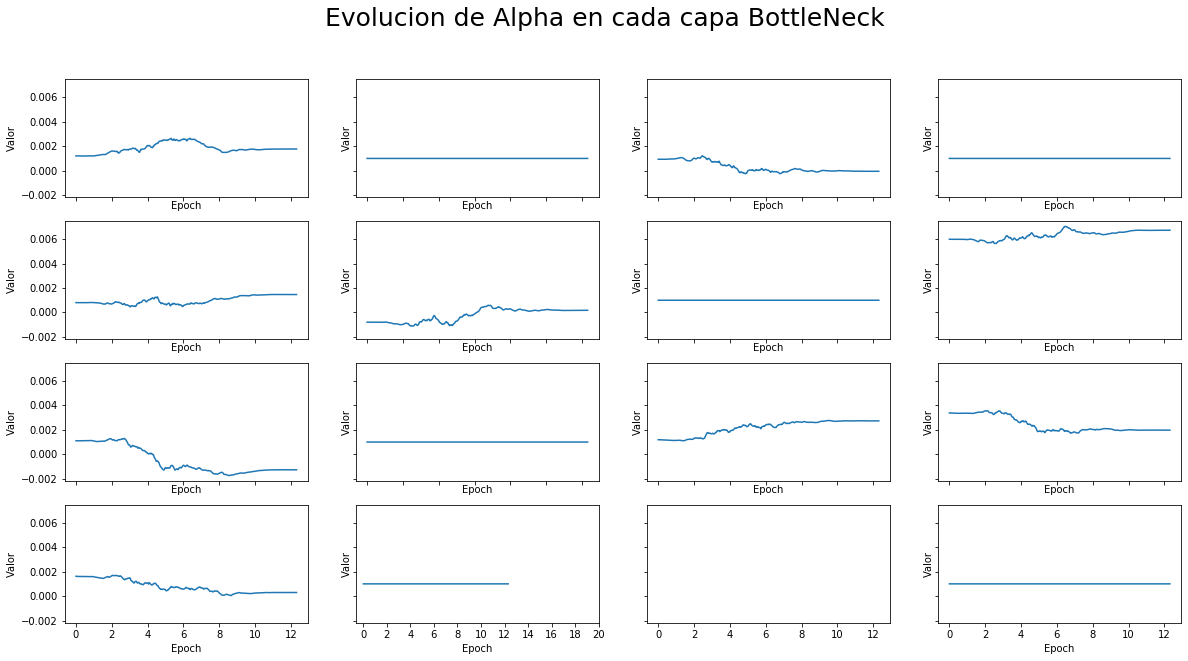

In [45]:
fig,axs = plt.subplots(4,4, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle('Evolucion de Alpha en cada capa BottleNeck', fontsize=25)
batches_per_epoch_with_oversampling = 203 #bs=16
epochs = 20 
for i in range(len(original_array)):
    ax = axs[(i-1) // 4, (i-1) % 4]    
    ax.plot(original_array[i])
    forward_passes = original_array[i];
    x_ticks_positions = [batches_per_epoch_with_oversampling * i for i in range(len(forward_passes))][:epochs+1][0::2]
    x_ticks_labels = list(range(epochs+1))[0::2]
    ax.set_xticks(x_ticks_positions) 
    ax.set_xticklabels(x_ticks_labels) 

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Valor')
    

# Comparing GradCAM

In [23]:
def train_variant_return_model(seed, epochs,transformation):
    data = reload_dataset(dm,seed)    
    
    model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)    
    transformation(model)
    
    random_seed(seed,True)
    
    learner = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                            callback_fns=[ShowGraph, OverSamplingCallback])

    learner.fit_one_cycle(4,max_lr=slice(3e-3))

    #Unfreeze
    learner.unfreeze()
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    return learner

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.966691,0.565130,0.286667,0.713333,0.696944,00:10
1,0.680819,0.512092,0.280000,0.720000,0.772778,00:10
2,0.576395,0.513683,0.233333,0.766667,0.746111,00:10
3,0.544562,0.446699,0.206667,0.793333,0.793333,00:10


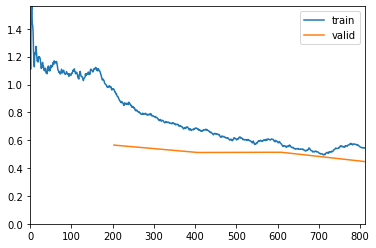

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.528503,0.452834,0.193333,0.806667,0.800833,00:16
1,0.538034,0.451340,0.200000,0.800000,0.809167,00:16
2,0.492595,0.399375,0.180000,0.820000,0.814722,00:16
3,0.489653,0.401567,0.166667,0.833333,0.828611,00:16
4,0.458448,0.407442,0.173333,0.826667,0.810278,00:16
5,0.403811,0.381030,0.180000,0.820000,0.831111,00:16
6,0.382925,0.372033,0.146667,0.853333,0.839444,00:16
7,0.327300,0.390709,0.160000,0.840000,0.840278,00:16
8,0.367844,0.374302,0.166667,0.833333,0.856944,00:16
9,0.317443,0.382959,0.160000,0.840000,0.865556,00:16


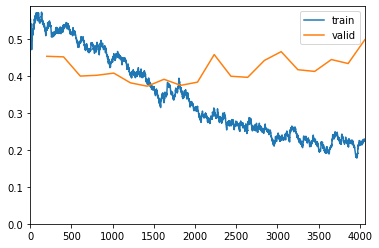

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.930055,1.031678,0.560000,0.440000,0.364722,00:09
1,0.741969,0.684493,0.213333,0.786667,0.366111,00:09
2,0.627709,0.522653,0.213333,0.786667,0.613333,00:09
3,0.601849,0.550453,0.206667,0.793333,0.525278,00:09


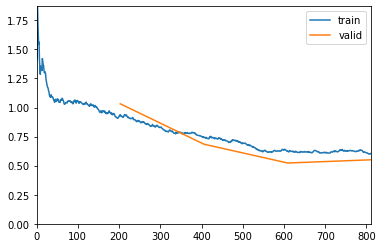

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.598514,0.547304,0.206667,0.793333,0.532222,00:13
1,0.598584,0.489581,0.200000,0.800000,0.662778,00:13
2,0.562105,0.493563,0.193333,0.806667,0.645278,00:13
3,0.544133,0.542095,0.206667,0.793333,0.594167,00:13
4,0.534087,0.522228,0.213333,0.786667,0.718889,00:13
5,0.496853,0.501465,0.206667,0.793333,0.720000,00:13
6,0.486636,0.499343,0.193333,0.806667,0.721944,00:13
7,0.420150,0.491020,0.186667,0.813333,0.743056,00:13
8,0.425851,0.543711,0.173333,0.826667,0.718056,00:13
9,0.428609,0.493219,0.173333,0.826667,0.765000,00:13


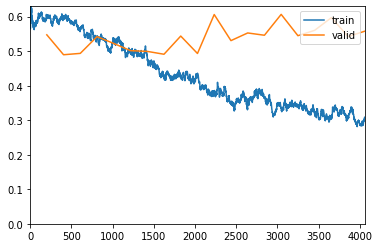

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.923144,0.910446,0.506667,0.493333,0.379722,00:09
1,0.750760,0.669022,0.226667,0.773333,0.388611,00:09
2,0.629446,0.505774,0.220000,0.780000,0.641944,00:09
3,0.610263,0.545196,0.193333,0.806667,0.556944,00:09


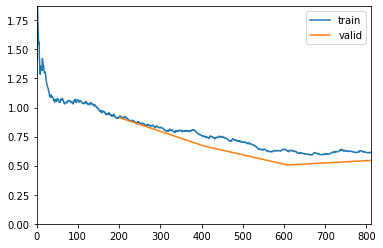

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.596932,0.540439,0.200000,0.800000,0.554167,00:14
1,0.600407,0.499273,0.220000,0.780000,0.651944,00:14
2,0.553814,0.508390,0.200000,0.800000,0.622222,00:14
3,0.551037,0.533290,0.206667,0.793333,0.602222,00:14
4,0.528495,0.524290,0.206667,0.793333,0.706389,00:14
5,0.487439,0.491869,0.206667,0.793333,0.724167,00:14
6,0.482452,0.495839,0.213333,0.786667,0.728889,00:14
7,0.431848,0.471120,0.173333,0.826667,0.751667,00:14
8,0.427933,0.537828,0.180000,0.820000,0.711111,00:14
9,0.428307,0.511105,0.180000,0.820000,0.748611,00:14


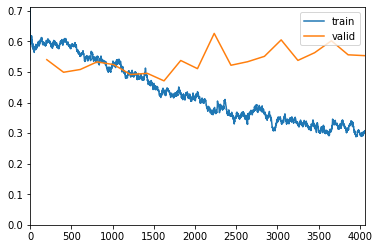

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.968461,0.555158,0.293333,0.706667,0.703889,00:11
1,0.685752,0.480791,0.253333,0.746667,0.786667,00:11
2,0.579218,0.483651,0.233333,0.766667,0.765000,00:11
3,0.537385,0.426332,0.180000,0.820000,0.800833,00:11


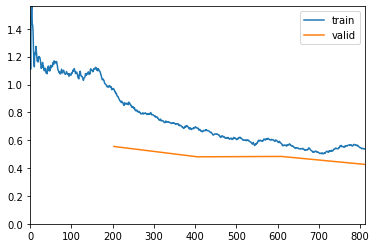

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.533090,0.433978,0.180000,0.820000,0.806389,00:17
1,0.533529,0.434748,0.200000,0.800000,0.809167,00:17
2,0.491665,0.411178,0.173333,0.826667,0.804444,00:17
3,0.485244,0.394414,0.146667,0.853333,0.830556,00:17
4,0.451455,0.418104,0.193333,0.806667,0.799722,00:17
5,0.399775,0.388105,0.180000,0.820000,0.822500,00:17
6,0.387601,0.374433,0.160000,0.840000,0.838889,00:17
7,0.330885,0.403994,0.166667,0.833333,0.827778,00:17
8,0.363800,0.386561,0.153333,0.846667,0.844167,00:17
9,0.312842,0.399973,0.160000,0.840000,0.861667,00:17


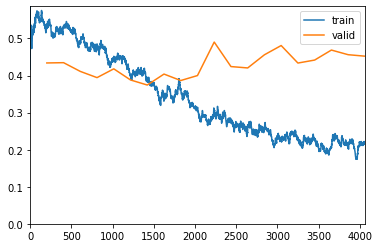

In [76]:
seed =4
epochs = 20

# #Baseline
learner_baseline = train_variant_return_model(seed, epochs, lambda x: x)

# #Without SE
learner_without_se  = train_variant_return_model(seed, epochs, remove_se_from_model)

#Without SE and With ARL
learner_without_se_with_arl = train_variant_return_model(seed, epochs,
                                                                   add_attn_geffnet_efficientnet_without_se)

#With everything
learner_with_arl = train_variant_return_model(seed, epochs, add_attn_geffnet_efficientnet)



In [77]:
interp_baseline = ClassificationInterpretation.from_learner(learner_baseline)
interp_without_se = ClassificationInterpretation.from_learner(learner_without_se)
interp_without_se_with_arl = ClassificationInterpretation.from_learner(learner_without_se_with_arl)
interp_with_arl = ClassificationInterpretation.from_learner(learner_with_arl)

In [78]:
preds_baseline = learner_baseline.get_preds()[0].argmax(dim=1)
preds_without_se = learner_without_se.get_preds()[0].argmax(dim=1)
preds_without_se_with_arl = learner_without_se_with_arl.get_preds()[0].argmax(dim=1)
preds_with_arl = learner_with_arl.get_preds()[0].argmax(dim=1)

In [79]:
_, actuals = learner_baseline.get_preds()
_, actuals_with_arl = learner_baseline.get_preds()

In [80]:
#sanity check
actuals == actuals_with_arl

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [81]:
sum(actuals == preds_baseline).item() / 150

0.8133333333333334

In [82]:
sum(actuals == preds_with_arl).item() / 150

0.8466666666666667

In [83]:
equals_preds = (preds_baseline == preds_with_arl)
[idx for idx in range(len(equals_preds)) if not equals_preds[idx] ]

[10, 19, 49, 59, 72, 84, 134]

In [48]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider


In [49]:
def f(i):
    interp_baseline.GradCAM(i)
    interp_without_se.GradCAM(i)
    interp_without_se_with_arl.GradCAM(i)
    interp_with_arl.GradCAM(i)

In [50]:
interact(f,i=IntSlider(min=0, max=150, step=1, continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=150), Output()), _dom_c…

# Comparison for various seeds

In [23]:
def train_variant(seed, epochs,transformation):
    data = reload_dataset(dm,seed)    
    
    model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)    
    transformation(model)
    
    random_seed(seed,True)
    
    learner = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                            callback_fns=[ShowGraph, OverSamplingCallback])

    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    aurocs = list(map(lambda x: x[2], learner.recorder.metrics))

    #Unfreeze
    learner.unfreeze()
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))
    aurocs += list(map(lambda x: x[2], learner.recorder.metrics))

    return accuracies, aurocs

In [25]:
results_file_name = 'results/second_take_efficientnet_attention_analysis_run_seed'
columns = ['Baseline_acc',
           'Baseline_auroc',
           'Without_SE_acc',
           'Without_SE_auroc', 
           "without_SE_with_ARL_acc",
           "without_SE_with_ARL_auroc", 
           "SE_and_ARL_acc",
           'SE_and_ARL_auroc']

In [19]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.997199,0.586012,0.233333,0.766667,0.727500,00:13
1,0.666269,0.502910,0.246667,0.753333,0.761111,00:10
2,0.573465,0.459720,0.213333,0.786667,0.783056,00:11
3,0.560333,0.417278,0.173333,0.826667,0.794722,00:11


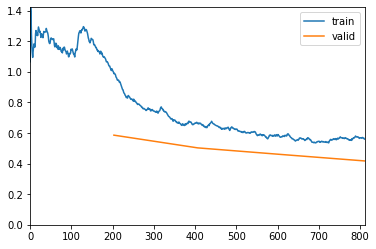

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.523180,0.405648,0.146667,0.853333,0.799444,00:17
1,0.513288,0.428453,0.173333,0.826667,0.802778,00:17
2,0.499407,0.439354,0.200000,0.800000,0.809167,00:17
3,0.505628,0.404003,0.186667,0.813333,0.811667,00:17
4,0.451468,0.411455,0.186667,0.813333,0.801389,00:17
5,0.429544,0.421003,0.180000,0.820000,0.818889,00:17
6,0.403984,0.380129,0.173333,0.826667,0.835000,00:17
7,0.347964,0.400422,0.173333,0.826667,0.832778,00:17
8,0.348842,0.379509,0.133333,0.866667,0.843889,00:17
9,0.310693,0.413325,0.160000,0.840000,0.834167,00:17


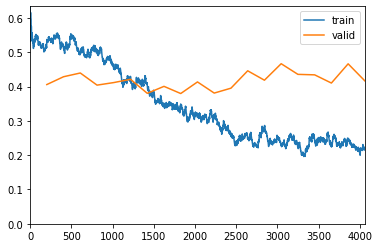

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.927139,0.668422,0.180000,0.820000,0.553889,00:09
1,0.753676,0.527633,0.200000,0.800000,0.677500,00:09
2,0.649371,0.563741,0.240000,0.760000,0.696944,00:09
3,0.607665,0.546705,0.186667,0.813333,0.540000,00:09


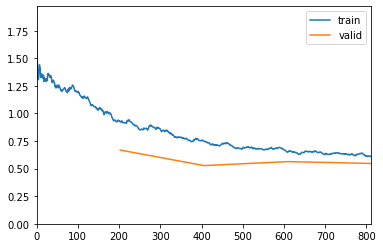

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.599572,0.559911,0.193333,0.806667,0.483611,00:14
1,0.577151,0.517195,0.200000,0.800000,0.588056,00:14
2,0.588722,0.498284,0.213333,0.786667,0.650000,00:14
3,0.571533,0.478079,0.193333,0.806667,0.679167,00:14
4,0.524023,0.520513,0.206667,0.793333,0.609444,00:14
5,0.488781,0.560029,0.220000,0.780000,0.614167,00:14
6,0.487795,0.466209,0.173333,0.826667,0.752500,00:14
7,0.440258,0.458212,0.160000,0.840000,0.754167,00:14
8,0.416963,0.498457,0.193333,0.806667,0.751667,00:14
9,0.426330,0.468270,0.180000,0.820000,0.749444,00:14


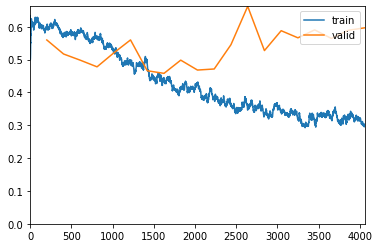

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.959563,0.820578,0.226667,0.773333,0.441389,00:09
1,0.760807,0.574877,0.206667,0.793333,0.618333,00:09
2,0.655392,0.598896,0.240000,0.760000,0.689167,00:09
3,0.606184,0.548223,0.213333,0.786667,0.528611,00:09


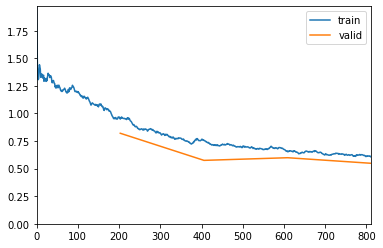

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.596372,0.555045,0.200000,0.800000,0.487222,00:15
1,0.578457,0.501451,0.193333,0.806667,0.615000,00:15
2,0.590476,0.513009,0.213333,0.786667,0.621667,00:15
3,0.563911,0.471248,0.193333,0.806667,0.693889,00:15
4,0.520421,0.520787,0.213333,0.786667,0.610278,00:15
5,0.480517,0.567004,0.213333,0.786667,0.607500,00:15
6,0.477612,0.481232,0.186667,0.813333,0.747778,00:15
7,0.445182,0.485036,0.166667,0.833333,0.733611,00:15
8,0.412400,0.517981,0.166667,0.833333,0.737222,00:15
9,0.420335,0.480874,0.180000,0.820000,0.733611,00:15


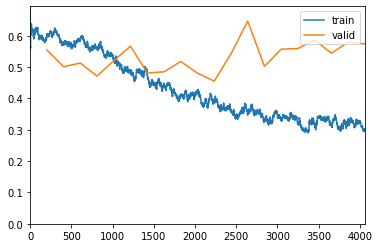

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.001008,0.575749,0.226667,0.773333,0.735000,00:11
1,0.668163,0.508374,0.253333,0.746667,0.736389,00:11
2,0.577093,0.466349,0.220000,0.780000,0.774167,00:11
3,0.563329,0.427600,0.153333,0.846667,0.784722,00:11


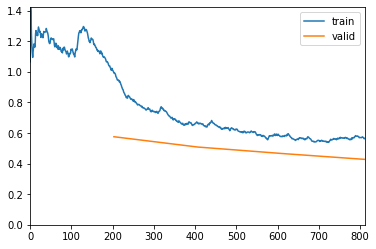

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.522304,0.410799,0.133333,0.866667,0.782500,00:18
1,0.512208,0.429000,0.186667,0.813333,0.796389,00:18
2,0.498083,0.435752,0.200000,0.800000,0.802500,00:18
3,0.502748,0.401288,0.186667,0.813333,0.811111,00:18
4,0.452804,0.401770,0.166667,0.833333,0.805278,00:18
5,0.429255,0.399195,0.173333,0.826667,0.829722,00:18
6,0.403933,0.363447,0.160000,0.840000,0.843333,00:18
7,0.341609,0.378828,0.160000,0.840000,0.844722,00:18
8,0.344813,0.376115,0.153333,0.846667,0.845556,00:18
9,0.315746,0.388648,0.146667,0.853333,0.840556,00:18


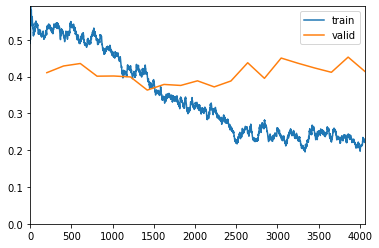

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.947353,0.533395,0.180000,0.820000,0.730000,00:11
1,0.658908,0.512396,0.226667,0.773333,0.763889,00:11
2,0.572728,0.529594,0.226667,0.773333,0.762500,00:11
3,0.535986,0.453712,0.213333,0.786667,0.790000,00:11


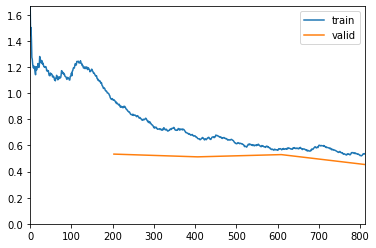

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.522411,0.427382,0.186667,0.813333,0.816111,00:17
1,0.527729,0.453105,0.226667,0.773333,0.790278,00:17
2,0.502593,0.408269,0.173333,0.826667,0.816667,00:17
3,0.487127,0.411292,0.193333,0.806667,0.810000,00:17
4,0.464468,0.384672,0.180000,0.820000,0.817778,00:17
5,0.415141,0.386552,0.160000,0.840000,0.832500,00:17
6,0.360867,0.388521,0.173333,0.826667,0.835555,00:17
7,0.359309,0.387835,0.160000,0.840000,0.833333,00:17
8,0.320800,0.416224,0.153333,0.846667,0.822778,00:17
9,0.328746,0.441681,0.180000,0.820000,0.818889,00:17


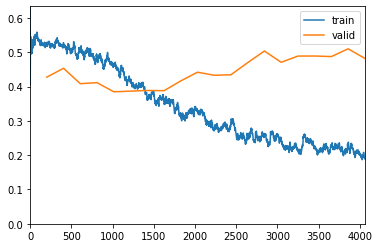

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.921797,0.698924,0.260000,0.740000,0.675556,00:09
1,0.717526,0.754531,0.433333,0.566667,0.461667,00:09
2,0.647227,0.601574,0.220000,0.780000,0.514722,00:09
3,0.607550,0.549607,0.200000,0.800000,0.576667,00:09


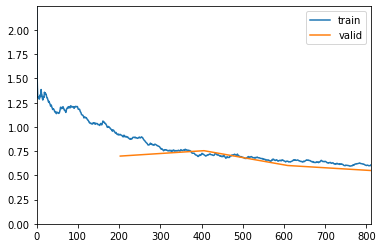

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.597830,0.521227,0.186667,0.813333,0.618333,00:14
1,0.608334,0.508523,0.220000,0.780000,0.683889,00:14
2,0.561806,0.650993,0.213333,0.786667,0.447500,00:14
3,0.574163,0.541977,0.200000,0.800000,0.570278,00:14
4,0.525773,0.523462,0.213333,0.786667,0.635833,00:14
5,0.518553,0.482014,0.186667,0.813333,0.685556,00:14
6,0.462197,0.437998,0.186667,0.813333,0.761389,00:14
7,0.440709,0.504977,0.206667,0.793333,0.743611,00:14
8,0.420517,0.624210,0.240000,0.760000,0.647500,00:14
9,0.409303,0.461255,0.200000,0.800000,0.797778,00:14


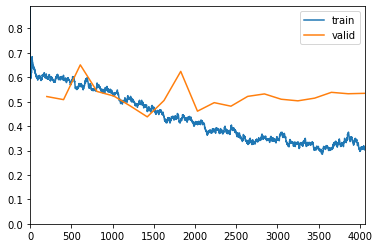

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.921815,0.672568,0.240000,0.760000,0.603611,00:09
1,0.736376,0.793942,0.433333,0.566667,0.441667,00:09
2,0.651566,0.609120,0.246667,0.753333,0.500000,00:09
3,0.609625,0.537775,0.193333,0.806667,0.603055,00:09


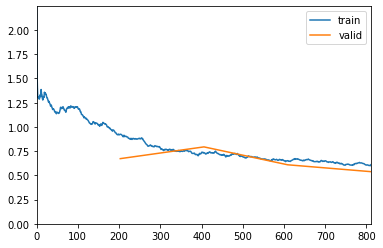

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.602314,0.520488,0.186667,0.813333,0.625000,00:15
1,0.610265,0.493421,0.226667,0.773333,0.693889,00:15
2,0.575506,0.640881,0.206667,0.793333,0.451389,00:15
3,0.570104,0.516270,0.193333,0.806667,0.607222,00:15
4,0.530809,0.496529,0.213333,0.786667,0.668611,00:15
5,0.513476,0.495050,0.200000,0.800000,0.678333,00:15
6,0.459049,0.472005,0.173333,0.826667,0.737222,00:15
7,0.429248,0.509227,0.206667,0.793333,0.732778,00:15
8,0.415633,0.647706,0.233333,0.766667,0.607778,00:15
9,0.403001,0.467097,0.206667,0.793333,0.771111,00:15


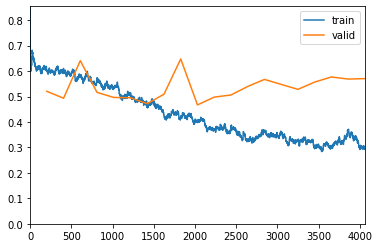

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.949867,0.551114,0.180000,0.820000,0.718055,00:11
1,0.660200,0.524284,0.233333,0.766667,0.762500,00:11
2,0.572763,0.524851,0.240000,0.760000,0.772222,00:11
3,0.531771,0.455773,0.213333,0.786667,0.792222,00:11


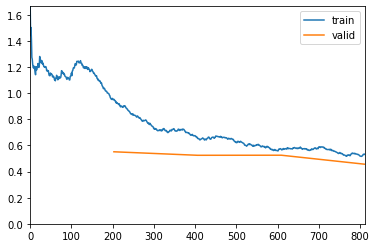

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.525503,0.440945,0.180000,0.820000,0.808333,00:18
1,0.535401,0.463183,0.226667,0.773333,0.791111,00:18
2,0.494137,0.413358,0.173333,0.826667,0.813333,00:18
3,0.489430,0.414617,0.193333,0.806667,0.807500,00:18
4,0.470675,0.377378,0.200000,0.800000,0.828611,00:18
5,0.418696,0.384113,0.186667,0.813333,0.835833,00:18
6,0.363782,0.393650,0.173333,0.826667,0.836389,00:18
7,0.354257,0.391741,0.173333,0.826667,0.837778,00:18
8,0.319439,0.424832,0.153333,0.846667,0.820556,00:18
9,0.328178,0.458451,0.193333,0.806667,0.810556,00:18


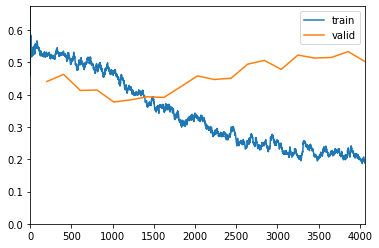

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.995824,0.793918,0.273333,0.726667,0.682778,00:11
1,0.649611,0.490796,0.246667,0.753333,0.783333,00:11
2,0.600190,0.397893,0.186667,0.813333,0.811111,00:11
3,0.544151,0.398124,0.160000,0.840000,0.820556,00:11


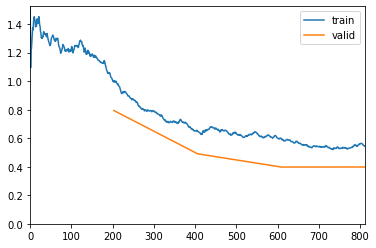

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.521227,0.392948,0.173333,0.826667,0.829167,00:17
1,0.496341,0.384533,0.160000,0.840000,0.838611,00:17
2,0.472635,0.406894,0.173333,0.826667,0.809167,00:17
3,0.475413,0.376833,0.193333,0.806667,0.839444,00:17
4,0.431769,0.391924,0.166667,0.833333,0.832222,00:17
5,0.417202,0.380264,0.166667,0.833333,0.832222,00:17
6,0.379526,0.390207,0.160000,0.840000,0.836667,00:17
7,0.352880,0.379479,0.153333,0.846667,0.836944,00:17
8,0.331531,0.369856,0.133333,0.866667,0.859444,00:17
9,0.302730,0.455946,0.173333,0.826667,0.831111,00:17


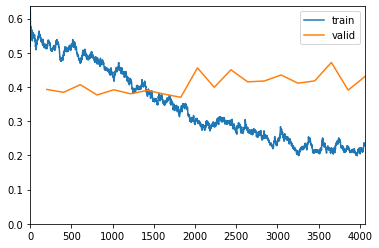

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.967702,0.656752,0.226667,0.773333,0.747500,00:09
1,0.733493,0.487189,0.213333,0.786667,0.756389,00:09
2,0.646204,0.541885,0.213333,0.786667,0.555556,00:09
3,0.617404,0.506289,0.213333,0.786667,0.620278,00:09


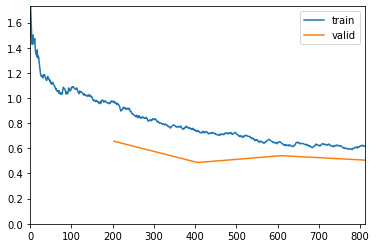

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.583890,0.497767,0.220000,0.780000,0.656389,00:14
1,0.577634,0.491241,0.233333,0.766667,0.671667,00:14
2,0.562274,0.537455,0.226667,0.773333,0.611667,00:14
3,0.532329,0.492567,0.200000,0.800000,0.701944,00:14
4,0.504054,0.459986,0.180000,0.820000,0.760278,00:14
5,0.500915,0.471732,0.200000,0.800000,0.733056,00:14
6,0.452820,0.519300,0.180000,0.820000,0.781944,00:14
7,0.425590,0.509407,0.186667,0.813333,0.761667,00:14
8,0.410199,0.536523,0.186667,0.813333,0.793889,00:14
9,0.392998,0.591547,0.200000,0.800000,0.743333,00:14


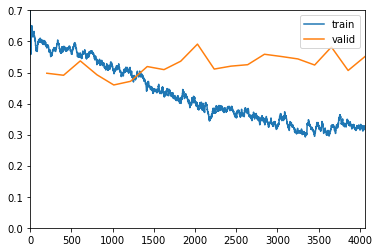

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.960163,0.732603,0.220000,0.780000,0.743333,00:09
1,0.717507,0.486482,0.233333,0.766667,0.736945,00:09
2,0.649366,0.551299,0.220000,0.780000,0.534722,00:09
3,0.620488,0.523749,0.206667,0.793333,0.591389,00:09


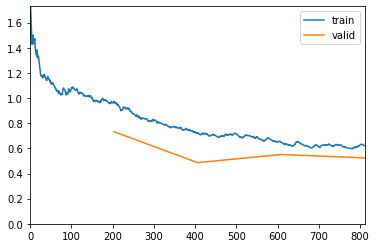

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.586001,0.514825,0.213333,0.786667,0.612778,00:15
1,0.576484,0.497989,0.226667,0.773333,0.663889,00:15
2,0.565646,0.558573,0.233333,0.766667,0.588889,00:15
3,0.533098,0.515980,0.206667,0.793333,0.684722,00:15
4,0.510004,0.452831,0.200000,0.800000,0.760278,00:15
5,0.503255,0.476460,0.213333,0.786667,0.732222,00:15
6,0.444249,0.553503,0.186667,0.813333,0.743333,00:15
7,0.415162,0.554119,0.206667,0.793333,0.731667,00:15
8,0.417192,0.585613,0.200000,0.800000,0.748056,00:15
9,0.396902,0.631699,0.193333,0.806667,0.686389,00:15


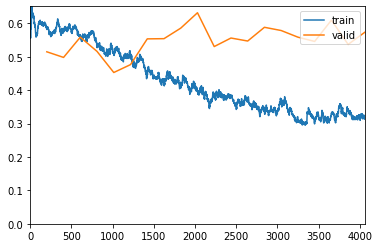

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.992298,0.780035,0.260000,0.740000,0.688611,00:11
1,0.653362,0.486227,0.226667,0.773333,0.768056,00:11
2,0.603858,0.388360,0.186667,0.813333,0.821111,00:11
3,0.539004,0.397651,0.186667,0.813333,0.818611,00:11


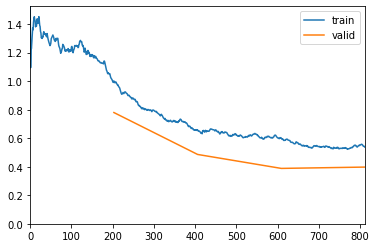

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.525439,0.393369,0.180000,0.820000,0.831944,00:18
1,0.506006,0.383878,0.146667,0.853333,0.831667,00:18
2,0.476700,0.406953,0.173333,0.826667,0.806944,00:18
3,0.479380,0.381829,0.166667,0.833333,0.835278,00:18
4,0.429436,0.394561,0.160000,0.840000,0.826944,00:18
5,0.415082,0.377739,0.153333,0.846667,0.831944,00:18
6,0.374285,0.374789,0.160000,0.840000,0.844722,00:18
7,0.355037,0.371936,0.146667,0.853333,0.843611,00:18
8,0.336186,0.357535,0.126667,0.873333,0.863056,00:18
9,0.306499,0.442805,0.160000,0.840000,0.833611,00:18


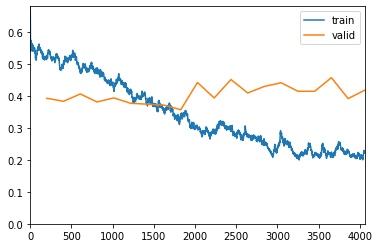

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.966691,0.565130,0.286667,0.713333,0.696944,00:11
1,0.680819,0.512092,0.280000,0.720000,0.772778,00:11
2,0.576395,0.513683,0.233333,0.766667,0.746111,00:11
3,0.544562,0.446699,0.206667,0.793333,0.793333,00:11


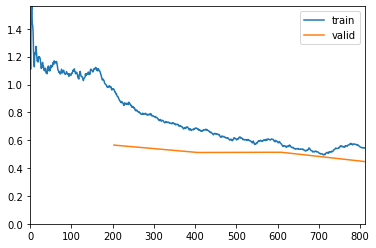

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.528503,0.452836,0.193333,0.806667,0.800833,00:17
1,0.538031,0.451365,0.200000,0.800000,0.809444,00:17
2,0.492610,0.399222,0.180000,0.820000,0.814722,00:17
3,0.489668,0.399811,0.166667,0.833333,0.828334,00:17
4,0.458141,0.407399,0.173333,0.826667,0.811111,00:17
5,0.403839,0.381873,0.173333,0.826667,0.831389,00:17
6,0.382703,0.373002,0.140000,0.860000,0.838333,00:17
7,0.326764,0.390117,0.160000,0.840000,0.839722,00:17
8,0.369110,0.375844,0.166667,0.833333,0.857222,00:17
9,0.317424,0.385099,0.153333,0.846667,0.865278,00:17


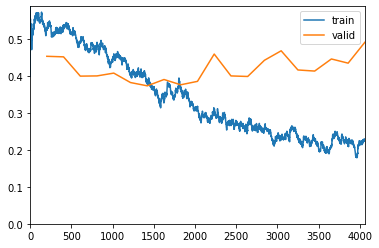

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.930055,1.031678,0.560000,0.440000,0.364722,00:09
1,0.741969,0.684493,0.213333,0.786667,0.366111,00:09
2,0.627709,0.522653,0.213333,0.786667,0.613333,00:09
3,0.601849,0.550453,0.206667,0.793333,0.525278,00:09


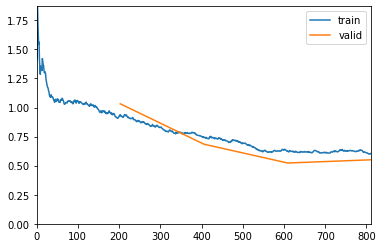

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.598514,0.547303,0.206667,0.793333,0.532222,00:14
1,0.598577,0.489574,0.200000,0.800000,0.663056,00:14
2,0.562078,0.493713,0.193333,0.806667,0.644722,00:14
3,0.544047,0.542399,0.206667,0.793333,0.594722,00:14
4,0.534362,0.523811,0.213333,0.786667,0.721111,00:14
5,0.496115,0.500583,0.220000,0.780000,0.720278,00:14
6,0.486582,0.499966,0.200000,0.800000,0.722222,00:14
7,0.419956,0.491581,0.193333,0.806667,0.746389,00:14
8,0.426291,0.551009,0.173333,0.826667,0.715278,00:14
9,0.428838,0.498737,0.180000,0.820000,0.761944,00:14


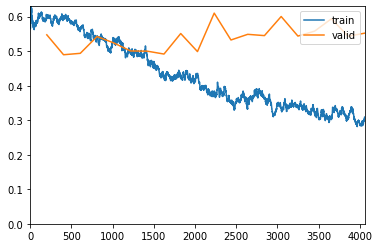

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.923144,0.910446,0.506667,0.493333,0.379722,00:09
1,0.750760,0.669022,0.226667,0.773333,0.388611,00:09
2,0.629446,0.505774,0.220000,0.780000,0.641944,00:09
3,0.610263,0.545196,0.193333,0.806667,0.556944,00:09


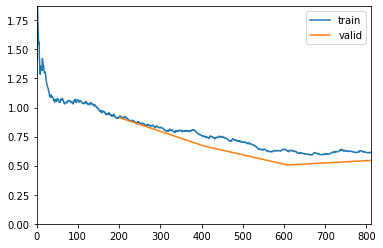

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.596932,0.540438,0.200000,0.800000,0.554167,00:15
1,0.600406,0.499279,0.220000,0.780000,0.651944,00:15
2,0.553811,0.508336,0.200000,0.800000,0.621667,00:15
3,0.551133,0.533883,0.206667,0.793333,0.603611,00:15
4,0.528282,0.528379,0.200000,0.800000,0.701944,00:15
5,0.486102,0.498731,0.213333,0.786667,0.718333,00:15
6,0.483762,0.499515,0.206667,0.793333,0.723611,00:15
7,0.430519,0.471371,0.173333,0.826667,0.751667,00:15
8,0.429458,0.537729,0.180000,0.820000,0.718333,00:15
9,0.428933,0.518948,0.173333,0.826667,0.740833,00:15


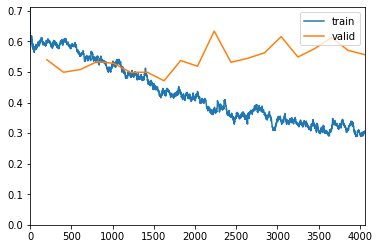

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.968461,0.555158,0.293333,0.706667,0.703889,00:11
1,0.685752,0.480791,0.253333,0.746667,0.786667,00:11
2,0.579218,0.483651,0.233333,0.766667,0.765000,00:11
3,0.537385,0.426332,0.180000,0.820000,0.800833,00:11


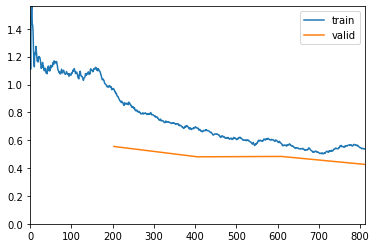

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.533090,0.433978,0.180000,0.820000,0.806389,00:18
1,0.533521,0.434817,0.200000,0.800000,0.809167,00:18
2,0.491663,0.411472,0.173333,0.826667,0.804167,00:18
3,0.485224,0.394228,0.146667,0.853333,0.830833,00:18
4,0.451513,0.417275,0.193333,0.806667,0.799167,00:18
5,0.399505,0.388475,0.180000,0.820000,0.822500,00:18
6,0.387889,0.374066,0.153333,0.846667,0.838889,00:18
7,0.331203,0.403382,0.166667,0.833333,0.828611,00:18
8,0.364073,0.389182,0.146667,0.853333,0.843055,00:18
9,0.311844,0.402889,0.160000,0.840000,0.858333,00:18


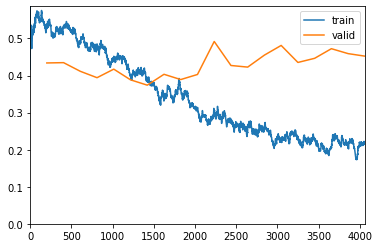

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.968082,0.659122,0.240000,0.760000,0.738055,00:11
1,0.671001,0.561113,0.260000,0.740000,0.696944,00:11
2,0.565807,0.542808,0.260000,0.740000,0.737222,00:11
3,0.513959,0.433580,0.213333,0.786667,0.819167,00:11


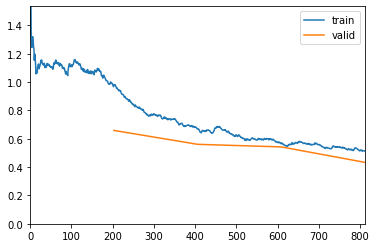

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.514543,0.423509,0.206667,0.793333,0.803056,00:17
1,0.533905,0.425822,0.193333,0.806667,0.808333,00:17
2,0.516555,0.409161,0.180000,0.820000,0.799722,00:17
3,0.467962,0.405875,0.186667,0.813333,0.796111,00:17
4,0.439820,0.396887,0.166667,0.833333,0.819167,00:17
5,0.402568,0.385422,0.180000,0.820000,0.844167,00:17
6,0.404265,0.399180,0.173333,0.826667,0.823056,00:17
7,0.356226,0.417246,0.160000,0.840000,0.817778,00:17
8,0.331228,0.422600,0.160000,0.840000,0.820278,00:17
9,0.316113,0.408454,0.140000,0.860000,0.824167,00:17


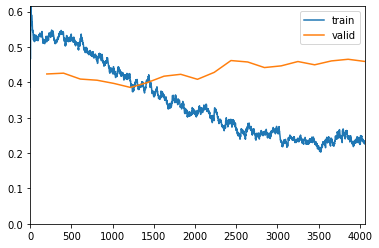

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.926162,0.866450,0.226667,0.773333,0.423333,00:09
1,0.728670,0.659994,0.260000,0.740000,0.418611,00:09
2,0.653185,0.541910,0.233333,0.766667,0.636111,00:09
3,0.597126,0.528525,0.186667,0.813333,0.633611,00:09


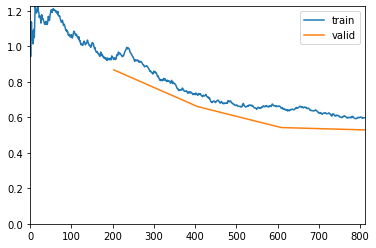

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.608839,0.543812,0.213333,0.786667,0.558333,00:14
1,0.593311,0.498226,0.200000,0.800000,0.667222,00:14
2,0.604944,0.560878,0.206667,0.793333,0.520555,00:14
3,0.556978,0.459655,0.206667,0.793333,0.706944,00:14
4,0.515351,0.450369,0.173333,0.826667,0.728333,00:14
5,0.486842,0.475401,0.220000,0.780000,0.739167,00:14
6,0.465492,0.495470,0.193333,0.806667,0.712222,00:14
7,0.448966,0.492548,0.206667,0.793333,0.770833,00:14
8,0.428504,0.458293,0.173333,0.826667,0.769167,00:14
9,0.414283,0.474060,0.193333,0.806667,0.761667,00:14


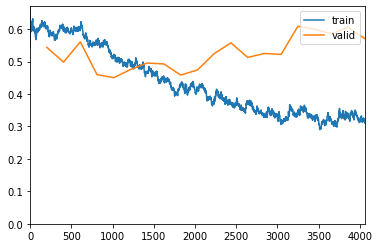

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.930134,0.831729,0.240000,0.760000,0.453611,00:09
1,0.727338,0.618149,0.260000,0.740000,0.496667,00:09
2,0.653407,0.555466,0.233333,0.766667,0.621667,00:09
3,0.598259,0.496266,0.173333,0.826667,0.672222,00:09


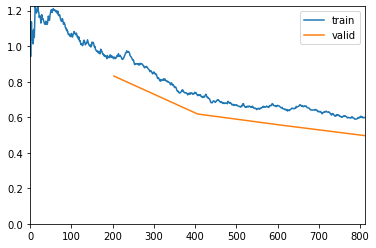

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.603934,0.506947,0.200000,0.800000,0.620000,00:15
1,0.598435,0.472548,0.180000,0.820000,0.700555,00:15
2,0.604855,0.540807,0.206667,0.793333,0.547778,00:15
3,0.553215,0.430220,0.186667,0.813333,0.742500,00:15
4,0.510617,0.438676,0.186667,0.813333,0.749167,00:15
5,0.487210,0.473228,0.193333,0.806667,0.750555,00:15
6,0.467668,0.485480,0.200000,0.800000,0.745833,00:15
7,0.452170,0.501717,0.186667,0.813333,0.778889,00:15
8,0.430479,0.451284,0.166667,0.833333,0.771944,00:15
9,0.413479,0.460514,0.193333,0.806667,0.773333,00:15


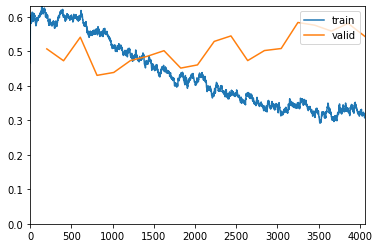

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.968884,0.642874,0.246667,0.753333,0.744722,00:11
1,0.671867,0.573915,0.306667,0.693333,0.687222,00:11
2,0.584600,0.541079,0.240000,0.760000,0.736944,00:11
3,0.518422,0.430088,0.186667,0.813333,0.823056,00:11


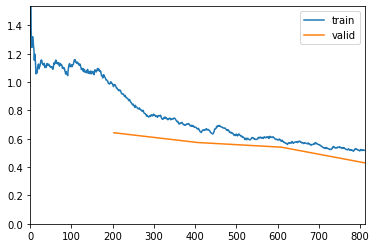

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.509673,0.420371,0.200000,0.800000,0.809445,00:18
1,0.527842,0.421820,0.186667,0.813333,0.813611,00:18
2,0.510307,0.404702,0.173333,0.826667,0.806111,00:18
3,0.461529,0.398817,0.173333,0.826667,0.804444,00:18
4,0.434318,0.390963,0.153333,0.846667,0.823333,00:18
5,0.402968,0.385422,0.166667,0.833333,0.836667,00:18
6,0.404287,0.407818,0.173333,0.826667,0.810000,00:18
7,0.357493,0.433168,0.153333,0.846667,0.804167,00:18
8,0.322182,0.435045,0.166667,0.833333,0.814167,00:18
9,0.311879,0.419866,0.160000,0.840000,0.814722,00:18


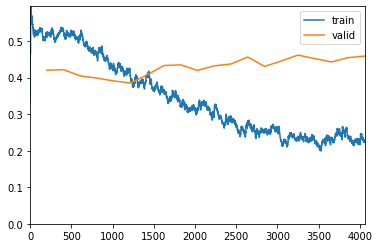

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.933859,0.710164,0.233333,0.766667,0.711667,00:11
1,0.692824,0.451873,0.180000,0.820000,0.766667,00:11
2,0.579033,0.437451,0.186667,0.813333,0.771111,00:11
3,0.542597,0.426452,0.200000,0.800000,0.803056,00:11


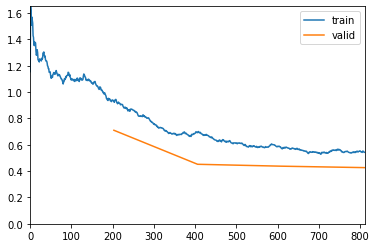

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.523205,0.430855,0.220000,0.780000,0.807778,00:17
1,0.512813,0.398657,0.193333,0.806667,0.820833,00:17
2,0.508743,0.397359,0.200000,0.800000,0.829167,00:17
3,0.500147,0.393941,0.153333,0.846667,0.837778,00:17
4,0.439529,0.374311,0.180000,0.820000,0.840555,00:17
5,0.413109,0.393871,0.160000,0.840000,0.828056,00:17
6,0.391225,0.397097,0.180000,0.820000,0.844722,00:17
7,0.358919,0.419841,0.186667,0.813333,0.811111,00:17
8,0.322918,0.367475,0.146667,0.853333,0.855000,00:17
9,0.303229,0.381817,0.140000,0.860000,0.849722,00:17


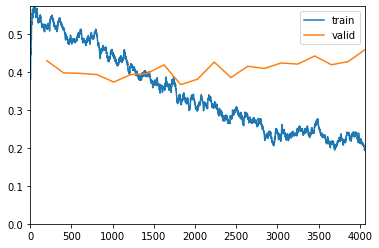

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.910533,0.926728,0.480000,0.520000,0.528611,00:09
1,0.735505,0.573112,0.220000,0.780000,0.528333,00:09
2,0.642134,0.546087,0.200000,0.800000,0.595000,00:09
3,0.608005,0.528812,0.226667,0.773333,0.616944,00:09


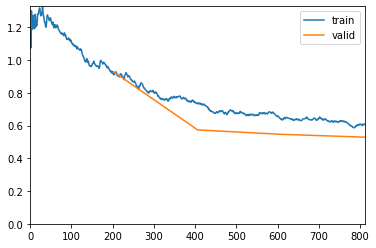

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.597241,0.521254,0.220000,0.780000,0.636667,00:14
1,0.578966,0.513965,0.213333,0.786667,0.625000,00:14
2,0.577050,0.504308,0.206667,0.793333,0.692778,00:14
3,0.551891,0.550406,0.200000,0.800000,0.597222,00:14
4,0.530104,0.504311,0.193333,0.806667,0.710833,00:14
5,0.517661,0.487983,0.193333,0.806667,0.698056,00:14
6,0.462121,0.523275,0.206667,0.793333,0.725278,00:14
7,0.444073,0.599298,0.240000,0.760000,0.642778,00:14
8,0.430996,0.502065,0.180000,0.820000,0.753611,00:14
9,0.390065,0.559624,0.206667,0.793333,0.710833,00:14


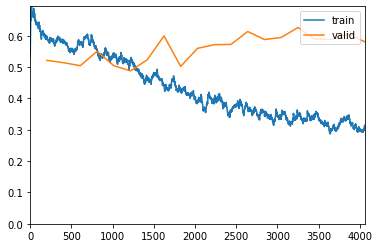

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.906885,0.810469,0.406667,0.593333,0.570000,00:09
1,0.740480,0.559070,0.213333,0.786667,0.579444,00:09
2,0.633175,0.535318,0.200000,0.800000,0.623056,00:09
3,0.610840,0.526868,0.233333,0.766667,0.631389,00:09


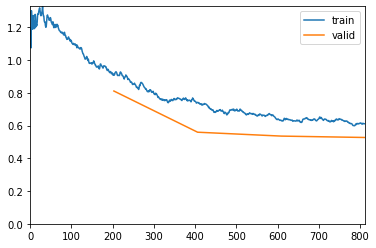

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.598149,0.517985,0.220000,0.780000,0.636944,00:15
1,0.571352,0.507056,0.206667,0.793333,0.640833,00:15
2,0.575988,0.503952,0.213333,0.786667,0.676111,00:15
3,0.546679,0.550596,0.200000,0.800000,0.592500,00:15
4,0.528305,0.479333,0.200000,0.800000,0.733333,00:15
5,0.517166,0.473498,0.193333,0.806667,0.718889,00:15
6,0.463565,0.506649,0.213333,0.786667,0.726944,00:15
7,0.442585,0.562768,0.240000,0.760000,0.673333,00:15
8,0.431546,0.491395,0.193333,0.806667,0.752222,00:15
9,0.383988,0.536219,0.220000,0.780000,0.739167,00:15


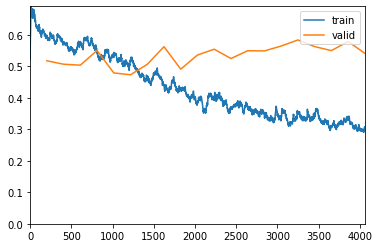

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.933976,0.705810,0.260000,0.740000,0.713889,00:11
1,0.689642,0.453623,0.173333,0.826667,0.766667,00:11
2,0.576379,0.440120,0.200000,0.800000,0.770556,00:11
3,0.542798,0.424477,0.200000,0.800000,0.800278,00:11


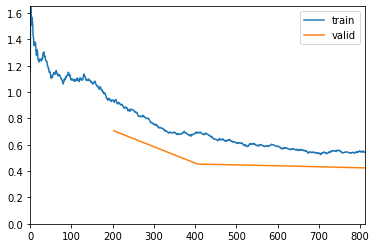

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.530273,0.426317,0.206667,0.793333,0.804167,00:18
1,0.517909,0.402229,0.180000,0.820000,0.812500,00:18
2,0.510160,0.396816,0.206667,0.793333,0.830833,00:18
3,0.486140,0.397334,0.180000,0.820000,0.824444,00:18
4,0.444970,0.393010,0.200000,0.800000,0.820000,00:18
5,0.405175,0.399052,0.160000,0.840000,0.827778,00:18
6,0.392124,0.411815,0.166667,0.833333,0.838611,00:18
7,0.357672,0.421868,0.180000,0.820000,0.813333,00:18
8,0.326770,0.359825,0.146667,0.853333,0.859444,00:18
9,0.303096,0.383566,0.140000,0.860000,0.851389,00:18


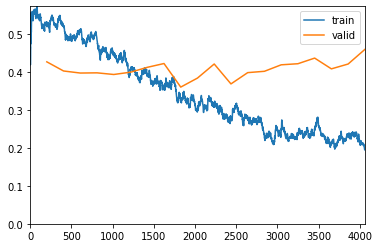

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.951866,0.479319,0.240000,0.760000,0.823889,00:11
1,0.659762,0.445957,0.226667,0.773333,0.800278,00:11
2,0.579199,0.449600,0.186667,0.813333,0.761667,00:11
3,0.545794,0.441690,0.206667,0.793333,0.808056,00:11


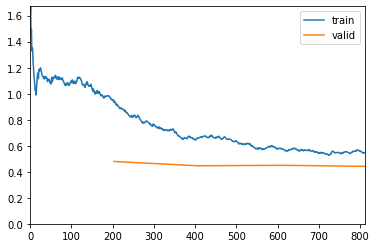

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.582519,0.419660,0.206667,0.793333,0.817778,00:17
1,0.510705,0.425723,0.220000,0.780000,0.800000,00:17
2,0.515898,0.386181,0.173333,0.826667,0.821944,00:17
3,0.486649,0.389007,0.193333,0.806667,0.821667,00:17
4,0.453159,0.408716,0.193333,0.806667,0.829722,00:17
5,0.396767,0.460308,0.206667,0.793333,0.788056,00:17
6,0.403676,0.385394,0.180000,0.820000,0.848889,00:17
7,0.357744,0.383309,0.173333,0.826667,0.847222,00:17
8,0.323570,0.402769,0.173333,0.826667,0.833056,00:17
9,0.298068,0.486580,0.186667,0.813333,0.809444,00:17


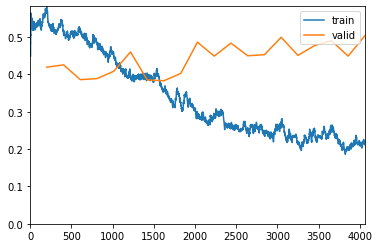

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.959121,0.627278,0.186667,0.813333,0.570000,00:09
1,0.742639,0.876422,0.426667,0.573333,0.306944,00:09
2,0.651470,0.599759,0.206667,0.793333,0.511111,00:09
3,0.615025,0.600767,0.206667,0.793333,0.502778,00:09


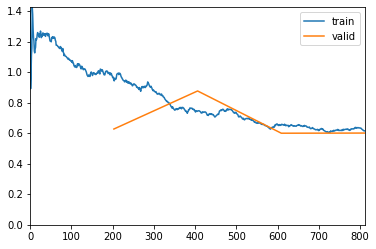

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.650045,0.541745,0.213333,0.786667,0.590556,00:14
1,0.581257,0.545648,0.233333,0.766667,0.562222,00:14
2,0.576177,0.482841,0.200000,0.800000,0.672222,00:14
3,0.565442,0.506120,0.200000,0.800000,0.674167,00:14
4,0.530963,0.474987,0.186667,0.813333,0.709444,00:14
5,0.508686,0.493318,0.173333,0.826667,0.711944,00:14
6,0.491118,0.474333,0.200000,0.800000,0.725833,00:14
7,0.445643,0.483083,0.180000,0.820000,0.743056,00:14
8,0.430435,0.480779,0.180000,0.820000,0.788611,00:14
9,0.398601,0.523679,0.166667,0.833333,0.748889,00:14


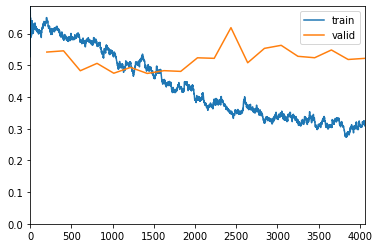

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.953006,0.562253,0.173333,0.826667,0.665833,00:09
1,0.744491,0.800537,0.280000,0.720000,0.322778,00:09
2,0.655343,0.646527,0.226667,0.773333,0.440556,00:09
3,0.628180,0.600184,0.206667,0.793333,0.470556,00:09


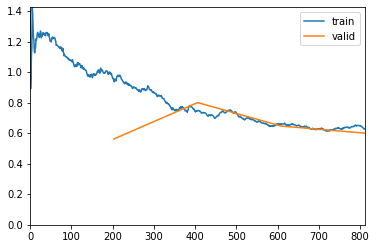

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.646280,0.534459,0.213333,0.786667,0.592778,00:15
1,0.591757,0.551854,0.206667,0.793333,0.538611,00:15
2,0.579458,0.483866,0.193333,0.806667,0.651528,00:15
3,0.562266,0.493759,0.193333,0.806667,0.690833,00:15
4,0.527902,0.477073,0.193333,0.806667,0.694445,00:15
5,0.509899,0.497306,0.173333,0.826667,0.691944,00:15
6,0.501935,0.466266,0.180000,0.820000,0.728333,00:15
7,0.447007,0.497689,0.200000,0.800000,0.706389,00:15
8,0.436777,0.467485,0.160000,0.840000,0.784722,00:15
9,0.401953,0.506515,0.173333,0.826667,0.738333,00:15


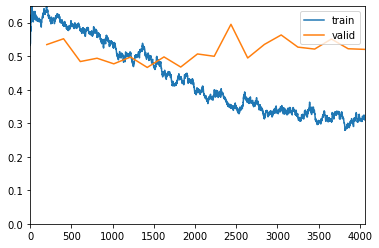

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.952798,0.468307,0.206667,0.793333,0.828611,00:11
1,0.659640,0.457833,0.226667,0.773333,0.797222,00:11
2,0.588613,0.488563,0.226667,0.773333,0.736944,00:11
3,0.542106,0.439803,0.200000,0.800000,0.799444,00:11


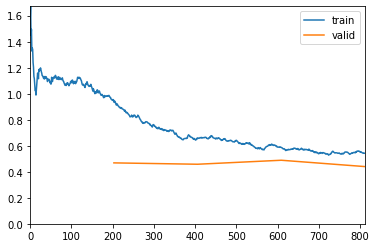

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.566743,0.424033,0.206667,0.793333,0.804722,00:18
1,0.513431,0.443685,0.213333,0.786667,0.788333,00:18
2,0.521904,0.389673,0.173333,0.826667,0.816111,00:18
3,0.487094,0.389208,0.186667,0.813333,0.824167,00:18
4,0.449076,0.409366,0.206667,0.793333,0.827222,00:18
5,0.392415,0.457850,0.206667,0.793333,0.788889,00:18
6,0.411788,0.386704,0.180000,0.820000,0.845833,00:18
7,0.355348,0.378257,0.166667,0.833333,0.855556,00:18
8,0.321989,0.394963,0.173333,0.826667,0.840000,00:18
9,0.292043,0.461408,0.173333,0.826667,0.816389,00:18


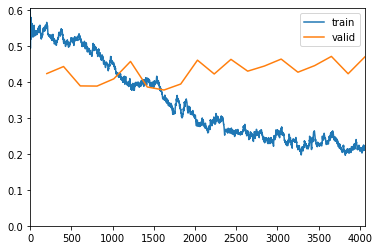

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.930531,0.612990,0.266667,0.733333,0.773611,00:11
1,0.694314,0.502023,0.226667,0.773333,0.764444,00:11
2,0.553388,0.431047,0.193333,0.806667,0.808333,00:11
3,0.552414,0.425527,0.186667,0.813333,0.821945,00:11


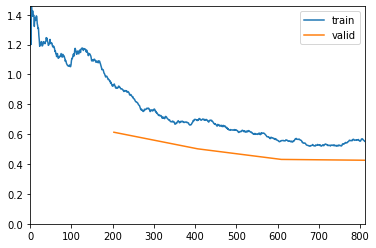

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.558438,0.406728,0.193333,0.806667,0.826667,00:17
1,0.522709,0.417363,0.200000,0.800000,0.824722,00:17
2,0.506270,0.387509,0.193333,0.806667,0.829722,00:17
3,0.467214,0.396195,0.193333,0.806667,0.830555,00:17
4,0.442815,0.388340,0.180000,0.820000,0.842500,00:17
5,0.400241,0.377121,0.173333,0.826667,0.843056,00:17
6,0.357120,0.392932,0.173333,0.826667,0.841667,00:17
7,0.366047,0.397840,0.193333,0.806667,0.835278,00:17
8,0.320513,0.401852,0.173333,0.826667,0.845833,00:17
9,0.310803,0.430609,0.166667,0.833333,0.829167,00:17


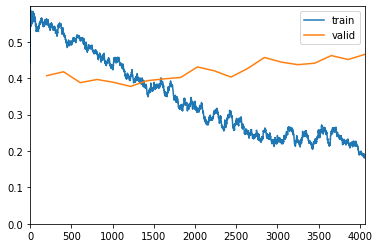

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.914213,1.889777,0.640000,0.360000,0.316389,00:09
1,0.763722,0.626567,0.253333,0.746667,0.436944,00:09
2,0.641501,0.531042,0.246667,0.753333,0.690833,00:09
3,0.596140,0.540054,0.220000,0.780000,0.594445,00:09


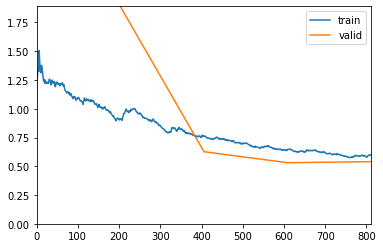

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.589218,0.550291,0.233333,0.766667,0.552778,00:14
1,0.578989,0.521538,0.220000,0.780000,0.599444,00:14
2,0.578922,0.498669,0.213333,0.786667,0.648333,00:14
3,0.540969,0.539849,0.213333,0.786667,0.599444,00:14
4,0.517738,0.443103,0.193333,0.806667,0.772500,00:14
5,0.468023,0.468092,0.180000,0.820000,0.741389,00:14
6,0.461691,0.515646,0.200000,0.800000,0.671111,00:14
7,0.456731,0.549687,0.200000,0.800000,0.669444,00:14
8,0.413428,0.596607,0.213333,0.786667,0.640000,00:14
9,0.413746,0.529585,0.200000,0.800000,0.721667,00:14


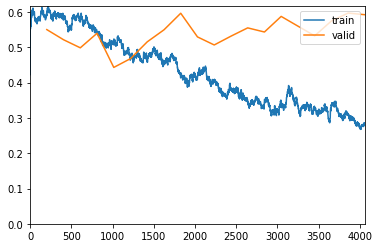

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.917161,2.024275,0.646667,0.353333,0.314167,00:09
1,0.770026,0.642409,0.233333,0.766667,0.445000,00:09
2,0.639404,0.547104,0.253333,0.746667,0.679444,00:09
3,0.597779,0.539210,0.213333,0.786667,0.601945,00:09


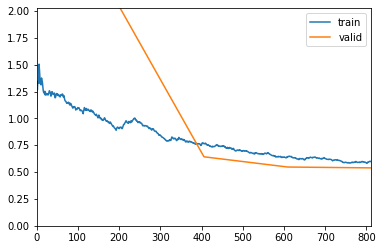

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.604564,0.547711,0.213333,0.786667,0.548611,00:15
1,0.591816,0.523810,0.200000,0.800000,0.575000,00:15
2,0.578092,0.494751,0.200000,0.800000,0.653611,00:15
3,0.541364,0.511358,0.193333,0.806667,0.649167,00:15
4,0.524992,0.418821,0.166667,0.833333,0.788056,00:15
5,0.465920,0.460718,0.193333,0.806667,0.744167,00:15
6,0.469046,0.495764,0.200000,0.800000,0.696944,00:15
7,0.462282,0.536426,0.206667,0.793333,0.710556,00:15
8,0.410735,0.603082,0.200000,0.800000,0.641389,00:15
9,0.413700,0.542300,0.213333,0.786667,0.717222,00:15


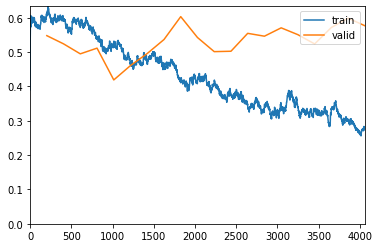

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.934776,0.631606,0.280000,0.720000,0.761667,00:11
1,0.695122,0.500354,0.246667,0.753333,0.784444,00:11
2,0.548424,0.449462,0.180000,0.820000,0.796389,00:11
3,0.543150,0.431676,0.173333,0.826667,0.820278,00:11


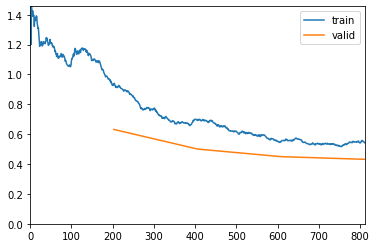

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.554740,0.413967,0.180000,0.820000,0.823056,00:18
1,0.522359,0.421273,0.200000,0.800000,0.822222,00:18
2,0.509827,0.392084,0.193333,0.806667,0.831667,00:18
3,0.461599,0.407702,0.180000,0.820000,0.823056,00:18
4,0.451382,0.401085,0.180000,0.820000,0.832222,00:18
5,0.398397,0.397918,0.186667,0.813333,0.830000,00:18
6,0.357739,0.406606,0.173333,0.826667,0.822778,00:18
7,0.365072,0.401806,0.166667,0.833333,0.826389,00:18
8,0.322314,0.416694,0.160000,0.840000,0.833611,00:18
9,0.310788,0.439282,0.160000,0.840000,0.809167,00:18


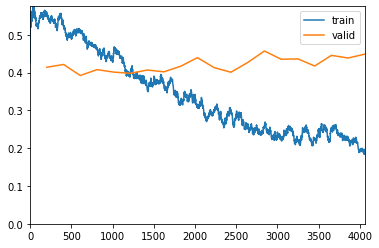

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.911101,0.577839,0.200000,0.800000,0.773055,00:11
1,0.677026,0.466862,0.226667,0.773333,0.786945,00:11
2,0.563023,0.391377,0.186667,0.813333,0.841389,00:11
3,0.552838,0.409839,0.200000,0.800000,0.818611,00:11


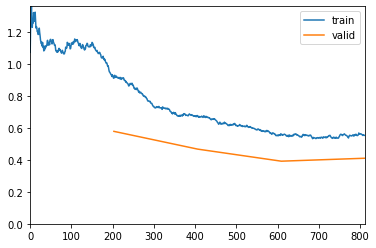

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.546405,0.415216,0.213333,0.786667,0.811111,00:17
1,0.502431,0.421173,0.200000,0.800000,0.813333,00:17
2,0.464982,0.399205,0.180000,0.820000,0.819167,00:17
3,0.480506,0.386553,0.206667,0.793333,0.835556,00:17
4,0.440058,0.385612,0.186667,0.813333,0.832778,00:17
5,0.377156,0.378190,0.160000,0.840000,0.838611,00:17
6,0.380973,0.379969,0.153333,0.846667,0.839722,00:17
7,0.354462,0.352082,0.140000,0.860000,0.862500,00:17
8,0.328826,0.401826,0.160000,0.840000,0.845000,00:17
9,0.298963,0.437188,0.166667,0.833333,0.805000,00:17


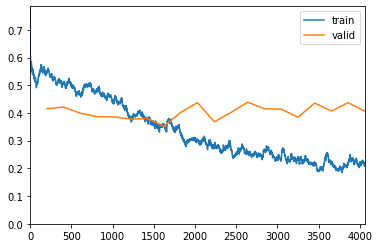

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.954404,0.702392,0.260000,0.740000,0.608889,00:09
1,0.720217,1.102332,0.580000,0.420000,0.307500,00:09
2,0.636901,0.553215,0.200000,0.800000,0.587778,00:09
3,0.598747,0.567662,0.220000,0.780000,0.536389,00:09


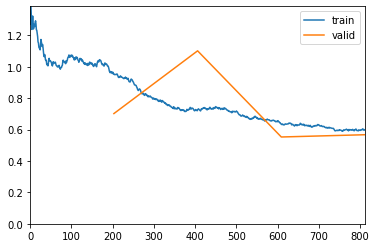

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.624732,0.538192,0.200000,0.800000,0.572222,00:14
1,0.591582,0.508444,0.193333,0.806667,0.623333,00:14
2,0.568914,0.481908,0.200000,0.800000,0.675278,00:14
3,0.554725,0.511865,0.193333,0.806667,0.616389,00:14
4,0.529654,0.555601,0.220000,0.780000,0.584167,00:14
5,0.473125,0.491647,0.193333,0.806667,0.685000,00:14
6,0.480416,0.471664,0.186667,0.813333,0.735278,00:14
7,0.460934,0.489315,0.180000,0.820000,0.726111,00:14
8,0.405477,0.466309,0.153333,0.846667,0.736111,00:14
9,0.388503,0.465820,0.186667,0.813333,0.747222,00:14


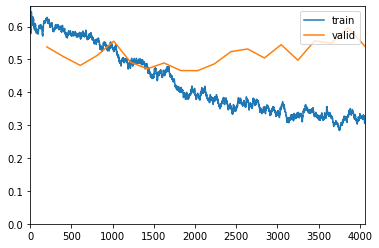

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.969103,0.716159,0.306667,0.693333,0.578889,00:09
1,0.726097,1.064454,0.560000,0.440000,0.301944,00:09
2,0.635601,0.521996,0.193333,0.806667,0.636111,00:09
3,0.601977,0.546791,0.220000,0.780000,0.568333,00:09


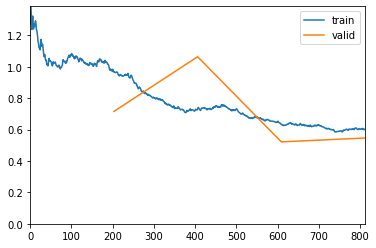

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.618549,0.525625,0.200000,0.800000,0.605000,00:15
1,0.583215,0.498938,0.180000,0.820000,0.641667,00:15
2,0.551816,0.474525,0.200000,0.800000,0.680833,00:15
3,0.549138,0.490850,0.186667,0.813333,0.653333,00:15
4,0.533120,0.544521,0.213333,0.786667,0.594444,00:15
5,0.482130,0.464802,0.166667,0.833333,0.708889,00:15
6,0.477412,0.468834,0.180000,0.820000,0.746111,00:15
7,0.456004,0.464415,0.180000,0.820000,0.742778,00:15
8,0.412840,0.451691,0.160000,0.840000,0.755556,00:15
9,0.400037,0.444709,0.166667,0.833333,0.765556,00:15


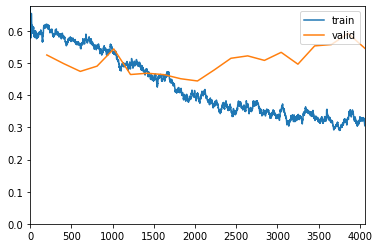

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.913489,0.592399,0.206667,0.793333,0.773055,00:11
1,0.677430,0.455514,0.193333,0.806667,0.773333,00:11
2,0.565920,0.417944,0.213333,0.786667,0.842222,00:11
3,0.553389,0.415601,0.213333,0.786667,0.823333,00:11


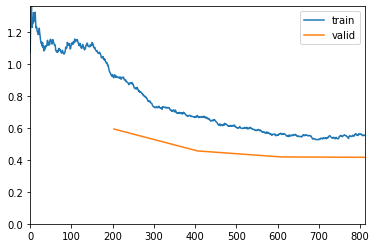

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.545925,0.423421,0.200000,0.800000,0.812500,00:18
1,0.502149,0.440886,0.226667,0.773333,0.813611,00:18
2,0.470219,0.404468,0.200000,0.800000,0.828056,00:18
3,0.488535,0.387347,0.200000,0.800000,0.842222,00:18
4,0.442515,0.392428,0.186667,0.813333,0.829722,00:18
5,0.380430,0.380197,0.173333,0.826667,0.842778,00:18
6,0.385855,0.391408,0.173333,0.826667,0.833611,00:18
7,0.348398,0.347215,0.133333,0.866667,0.858889,00:18
8,0.325034,0.389173,0.160000,0.840000,0.852500,00:18
9,0.296572,0.445385,0.180000,0.820000,0.801667,00:18


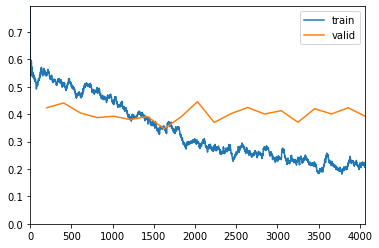

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.967038,0.501934,0.180000,0.820000,0.755833,00:11
1,0.668113,0.463370,0.240000,0.760000,0.799444,00:11
2,0.622546,0.410903,0.213333,0.786667,0.822500,00:11
3,0.540893,0.414462,0.220000,0.780000,0.798056,00:11


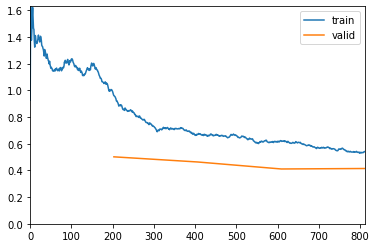

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.515145,0.410780,0.193333,0.806667,0.805833,00:17
1,0.520060,0.411237,0.193333,0.806667,0.797778,00:17
2,0.480111,0.404747,0.186667,0.813333,0.807778,00:17
3,0.475825,0.427650,0.180000,0.820000,0.798889,00:17
4,0.445327,0.399888,0.166667,0.833333,0.812778,00:17
5,0.429023,0.371850,0.180000,0.820000,0.831667,00:17
6,0.378674,0.391225,0.166667,0.833333,0.818611,00:17
7,0.363377,0.418387,0.153333,0.846667,0.818055,00:17
8,0.329399,0.409666,0.166667,0.833333,0.823889,00:17
9,0.288382,0.394822,0.160000,0.840000,0.846667,00:17


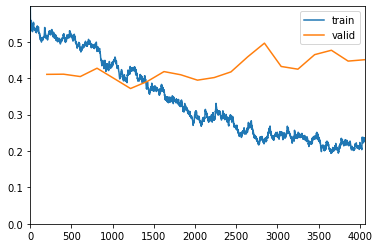

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.935244,0.663393,0.233333,0.766667,0.523889,00:09
1,0.749620,0.577467,0.240000,0.760000,0.552500,00:09
2,0.680016,0.542499,0.200000,0.800000,0.541389,00:09
3,0.596447,0.505593,0.206667,0.793333,0.629167,00:09


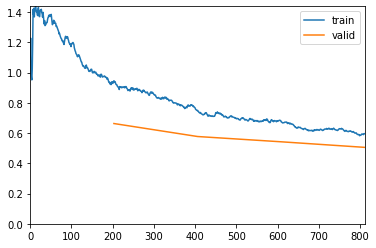

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.591424,0.503200,0.206667,0.793333,0.652778,00:14
1,0.611137,0.518700,0.213333,0.786667,0.636389,00:14
2,0.549985,0.533328,0.213333,0.786667,0.623333,00:14
3,0.545541,0.519389,0.200000,0.800000,0.668889,00:14
4,0.511030,0.532128,0.186667,0.813333,0.644722,00:14
5,0.505710,0.514358,0.180000,0.820000,0.671667,00:14
6,0.484560,0.500484,0.160000,0.840000,0.695556,00:14
7,0.439813,0.494206,0.200000,0.800000,0.752222,00:14
8,0.418319,0.534824,0.240000,0.760000,0.730278,00:14
9,0.411824,0.566501,0.213333,0.786667,0.692500,00:14


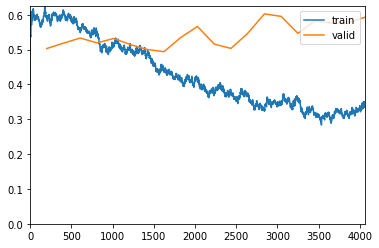

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.937510,0.629591,0.240000,0.760000,0.556944,00:09
1,0.737090,0.605970,0.233333,0.766667,0.523333,00:09
2,0.679062,0.550946,0.220000,0.780000,0.546111,00:09
3,0.583745,0.509630,0.226667,0.773333,0.653055,00:09


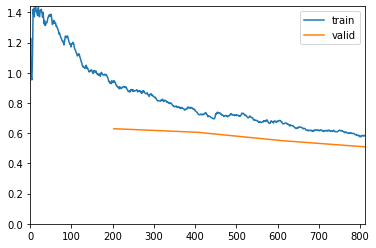

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.592476,0.504273,0.226667,0.773333,0.660556,00:15
1,0.603208,0.528707,0.226667,0.773333,0.631111,00:15
2,0.547633,0.544282,0.213333,0.786667,0.613889,00:15
3,0.550906,0.530087,0.220000,0.780000,0.645833,00:15
4,0.501051,0.554639,0.193333,0.806667,0.627500,00:15
5,0.516356,0.544761,0.193333,0.806667,0.634444,00:15
6,0.488426,0.518647,0.186667,0.813333,0.673333,00:15
7,0.444285,0.500274,0.200000,0.800000,0.742500,00:15
8,0.420643,0.570959,0.233333,0.766667,0.697222,00:15
9,0.413869,0.601336,0.213333,0.786667,0.643889,00:15


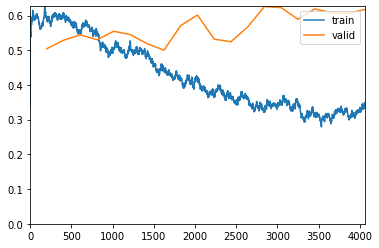

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.970461,0.502338,0.213333,0.786667,0.759722,00:11
1,0.678201,0.492662,0.273333,0.726667,0.784722,00:11
2,0.627756,0.401970,0.206667,0.793333,0.819167,00:11
3,0.544262,0.420483,0.206667,0.793333,0.798611,00:11


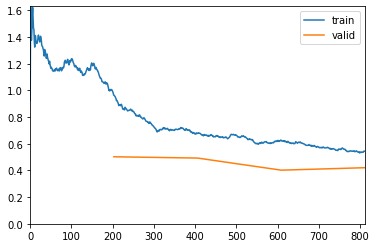

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.517084,0.408630,0.213333,0.786667,0.808056,00:18
1,0.522718,0.422883,0.186667,0.813333,0.796111,00:18
2,0.482015,0.404504,0.186667,0.813333,0.810833,00:18
3,0.470637,0.418749,0.193333,0.806667,0.803611,00:18
4,0.441525,0.395774,0.166667,0.833333,0.819444,00:18
5,0.430256,0.371996,0.160000,0.840000,0.830278,00:18
6,0.384395,0.388611,0.160000,0.840000,0.822222,00:18
7,0.364984,0.415770,0.146667,0.853333,0.818056,00:18
8,0.334002,0.406907,0.166667,0.833333,0.823056,00:18
9,0.290889,0.396512,0.160000,0.840000,0.846944,00:18


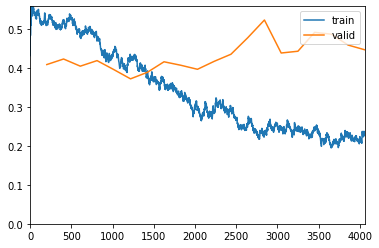

In [27]:
seeds = range(1,11)
# seeds = [1,2,3,4,5,6,7,8,9,10]
epochs = 20

for seed in seeds:
    
    
    #Baseline
    baseline_acc, baseline_auroc = train_variant(seed, epochs, lambda x: x)
    
    #Without SE
    without_SE_acc, without_SE_auroc  = train_variant(seed, epochs, remove_se_from_model)

    #Without SE and With ARL
    without_SE_with_ARL_acc, without_SE_with_ARL_auroc = train_variant(seed, epochs,
                                                                       add_attn_geffnet_efficientnet_without_se)

    #With everything
    SE_and_ARL_acc, SE_and_ARL_auroc = train_variant(seed, epochs, add_attn_geffnet_efficientnet)


    #write results
    write_results(seed, 
                  baseline_acc, 
                  baseline_auroc, 
                  without_SE_acc, 
                  without_SE_auroc,
                  without_SE_with_ARL_acc,
                  without_SE_with_ARL_auroc,
                  SE_and_ARL_acc,
                  SE_and_ARL_auroc)
    

# Workbench


In [84]:
data = reload_dataset(dm,seed)    

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)    

random_seed(seed,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph, OverSamplingCallback])


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.953515,0.488044,0.220000,0.780000,0.779444,00:20
1,0.845295,0.495213,0.233333,0.766667,0.785833,00:20
2,0.659067,0.458218,0.186667,0.813333,0.767778,00:20
3,0.508733,0.357746,0.146667,0.853333,0.854722,00:20
4,0.450949,0.371491,0.153333,0.846667,0.830833,00:20
5,0.415544,0.377009,0.173333,0.826667,0.842500,00:20
6,0.389209,0.387435,0.153333,0.846667,0.828333,00:20
7,0.361335,0.330992,0.140000,0.860000,0.883611,00:20
8,0.350715,0.371235,0.146667,0.853333,0.832222,00:20
9,0.350387,0.619893,0.280000,0.720000,0.803333,00:20


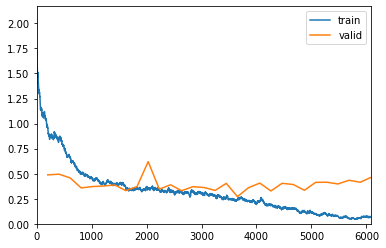

In [85]:
epochs = 30
learn.unfreeze()
learn.fit_one_cycle(epochs, max_lr=slice(3e-03),wd=1)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.978970,0.494930,0.206667,0.793333,0.777500,00:20
1,0.919123,0.551633,0.233333,0.766667,0.771389,00:20
2,0.759119,0.512399,0.180000,0.820000,0.761389,00:20
3,0.562584,0.355366,0.173333,0.826667,0.858333,00:20
4,0.505856,0.399609,0.146667,0.853333,0.831944,00:20
5,0.467463,0.411326,0.193333,0.806667,0.807778,00:20
6,0.439848,0.477059,0.166667,0.833333,0.780556,00:20
7,0.393601,0.432965,0.140000,0.860000,0.851389,00:20
8,0.375394,0.364235,0.153333,0.846667,0.842222,00:20
9,0.336696,0.451016,0.193333,0.806667,0.817222,00:20


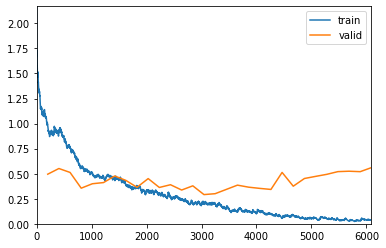

In [83]:
epochs = 30
learn.unfreeze()
learn.fit_one_cycle(epochs, max_lr=slice(3e-03),wd=0.1)